## Simulating ancestral structure

### In this notebook we use msprime to simulate 100 replicates of two demographic models:
### - Ancestral structure
### - No ancestral structure
### For each replicate simulation we are sampling a single diploid genome from each of three populations. 
### Each "genome" is comprised of 500 blocks of 5Mb length sequence (reflecting the chunking technique used by TTo method for weighted block jackknife estimation of means and CIs)
### The TTo method's estimates of T1 and T2 (the two estimates of divergence time in a split model) are then plotted for each demographic model.

In [1]:
# Import required libraries
import msprime
from dataclasses import dataclass
from __future__ import annotations
import configparser
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import random
import tqdm  # for progress bar

In [2]:
# Define high level loop
n_simulations = 100

In [ ]:
sim_results = []

In [3]:
# ---------------------
# Parameters
# ---------------------
@dataclass
class SimParams:
    # Genome and rates
    sequence_length: float = 5_000_000
    recombination_rate: float = 1.2e-8
    mutation_rate: float = 1.45e-8
    discrete_genome: bool = False

    # Demographic model times (years)
    generation_time_y: float = 29.0
    t_join_AB_y: float = 300_000.0
    t_ancestral_structure_start_y: float = 350_000.0
    t_ancestral_structure_end_y: float = 550_000.0
    t_outgroup_split_y: float = 600_000.0
    t_outgroup_sampling_y: float = 40_000.0

    # Population sizes
    Ne_A: int = 10_000
    Ne_B: int = 10_000
    Ne_AB: int = 10_000
    Ne_X: int = 10_000
    Ne_Y: int = 10_000
    Ne_ANC: int = 10_000
    Ne_OUT: int = 10_000
    Ne_ROOT: int = 10_000

    # sampling counts (number of diploids)
    n_diploid_A: int = 1
    n_diploid_B: int = 1
    n_diploid_OUT: int = 1

    num_replicates: int = 500

def years_to_gens(years: float, gen_time: float) -> float:
    return float(years) / float(gen_time)

In [4]:
# Define the demographic model function
def build_demography(p: SimParams) -> msprime.Demography:
    dem = msprime.Demography()

    # Define populations used
    dem.add_population(name="A", initial_size=p.Ne_A)
    dem.add_population(name="B", initial_size=p.Ne_B)
    dem.add_population(name="AB", initial_size=p.Ne_AB)
    dem.add_population(name="X", initial_size=p.Ne_X)
    dem.add_population(name="Y", initial_size=p.Ne_Y)
    dem.add_population(name="ANC", initial_size=p.Ne_ANC)
    dem.add_population(name="OUT", initial_size=p.Ne_OUT,
                      default_sampling_time=years_to_gens(p.t_outgroup_sampling_y, p.generation_time_y))
    dem.add_population(name="ROOT", initial_size=p.Ne_ROOT)

    # Convert event times to generations
    t_join_AB = years_to_gens(p.t_join_AB_y, p.generation_time_y)
    t_ancestral_structure_start = years_to_gens(p.t_ancestral_structure_start_y, p.generation_time_y)
    t_ancestral_structure_end = years_to_gens(p.t_ancestral_structure_end_y, p.generation_time_y)
    t_outgroup_split = years_to_gens(p.t_outgroup_split_y, p.generation_time_y)

    if not (0.0 < t_join_AB < t_ancestral_structure_start < t_ancestral_structure_end < t_outgroup_split):
        raise ValueError(
            "Times for demography not as expected.\n"
            f"Got (in generations): true A B divergence time={t_join_AB:.3f}, start structure={t_ancestral_structure_start:.3f}, "
            f"end structure={t_ancestral_structure_end:.3f}, outgroup split={t_outgroup_split:.3f}")

    # Oldest: ROOT -> (ANC, OUT)
    dem.add_population_split(time=t_outgroup_split, derived=["ANC", "OUT"], ancestral="ROOT")
    # ANC -> (X, Y)
    dem.add_population_split(time=t_ancestral_structure_end, derived=["X", "Y"], ancestral="ANC")
    # (X, Y) -> AB
    dem.add_admixture(time=t_ancestral_structure_start, derived="AB", ancestral=["X", "Y"], proportions=[0.5, 0.5])
    # AB -> (A, B)
    dem.add_population_split(time=t_join_AB, derived=["A", "B"], ancestral="AB")

    return dem

P = SimParams()
DEM = build_demography(P)
DEM.sort_events()
dbg = msprime.DemographyDebugger(demography=DEM)
dbg.print_history()

DemographyDebugger
╠═════════════════════════════════════╗
║ Epoch[0]: [0, 1.03e+04) generations ║
╠═════════════════════════════════════╝
╟    Populations (total=8 active=5)
║    ┌───────────────────────────────────────────────────────────────┐
║    │     │     start│       end│growth_rate  │ A │ B │ X │ Y │ OUT │
║    ├───────────────────────────────────────────────────────────────┤
║    │    A│   10000.0│   10000.0│ 0           │ 0 │ 0 │ 0 │ 0 │  0  │
║    │    B│   10000.0│   10000.0│ 0           │ 0 │ 0 │ 0 │ 0 │  0  │
║    │    X│   10000.0│   10000.0│ 0           │ 0 │ 0 │ 0 │ 0 │  0  │
║    │    Y│   10000.0│   10000.0│ 0           │ 0 │ 0 │ 0 │ 0 │  0  │
║    │  OUT│   10000.0│   10000.0│ 0           │ 0 │ 0 │ 0 │ 0 │  0  │
║    └───────────────────────────────────────────────────────────────┘
╟    Events @ generation 1.03e+04
║    ┌─────────────────────────────────────────────────────────────────────────────────┐
║    │       time│type        │parameters       │effect        

In [20]:
# -------------------
# Sampling (diploid individuals)
# -------------------

def make_samples(p: SimParams) -> List[msprime.SampleSet]:
    samples: List[msprime.SampleSet] = []
    if p.n_diploid_A > 0:
        samples.append(msprime.SampleSet(num_samples=p.n_diploid_A, population="A", ploidy=2))
    if p.n_diploid_B > 0:
        samples.append(msprime.SampleSet(num_samples=p.n_diploid_B, population="B", ploidy=2))
    if p.n_diploid_OUT > 0:
        samples.append(msprime.SampleSet(num_samples=p.n_diploid_OUT, population="OUT", ploidy=2))
        return samples

samples = make_samples(P)

In [21]:
# Function to count allele configurations for A and B, ensuring valid configurations only
def count_AB_configurations(A, B):
    # Ensure all genotypes are either 0 or 1
    if any(a not in [0, 1] for a in A) or any(b not in [0, 1] for b in B):
        return None  # Return None for invalid genotypes (not biallelic)
    
    # Sum the two alleles for population A and B to get number of derived alleles
    config = (sum(A), sum(B))  # Sum gives us a tuple like (0, 2), (1, 1), etc.
    
    # Ensure that we only return valid configurations (0, 0) to (2, 2)
    if config in valid_configs:
        return config
    else:
        return None  # Invalid configuration, should not be counted

# Helper functions to check the state of Population C
def is_heterozygous_OUT(out):
    return sum(out) == 1  # Heterozygous: 1 derived allele in C


In [22]:
# Set of parameter calculation equations based on ascertainment scheme
def calculate_parameters(m_counts_all_sites, m_counts_scheme, scheme):
    """
    Calculate alpha1 and alpha2 using the mcounts from ascertained sites in outgroup,
    then calculate T1, T2, etc. using the mcounts from All_sites.
    """
    # Calculate m_tot (total count of all sites)
    m_tot_all_sites = m_counts_all_sites.sum()

    # Step 1: Estimate alpha1 and alpha2 using the mcounts from the specific scheme
    if scheme == 'All_sites':
        alpha1 = (2 * m_counts_scheme['m11']) / (2 * m_counts_scheme['m21'] + m_counts_scheme['m11'])
        alpha2 = (2 * m_counts_scheme['m11']) / (2 * m_counts_scheme['m12'] + m_counts_scheme['m11'])
    else:
        # Correct formulas for heterozygous derived schemes
        alpha1 = (m_counts_scheme['m10'] + m_counts_scheme['m12'] + m_counts_scheme['m11']) / (m_counts_scheme['m10'] + 2 * m_counts_scheme['m20'] + m_counts_scheme['m21'] + 0.5 * m_counts_scheme['m11'])
        alpha2 = (m_counts_scheme['m01'] + m_counts_scheme['m21'] + m_counts_scheme['m11']) / (m_counts_scheme['m01'] + 2 * m_counts_scheme['m02'] + m_counts_scheme['m12'] + 0.5 * m_counts_scheme['m11'])

    # Step 2: Use the alphas estimated from the specific scheme,
    # but apply them to the All_sites mcounts for calculating T1, T2, etc.
    if scheme == 'All_sites':
        # Use All_sites mcounts directly for T1, T2, etc.
        mu_T1_p1 = m_counts_all_sites['m20'] + 0.5 * m_counts_all_sites['m10']
        mu_T1_p2 = (m_counts_all_sites['m11'] + 2.0 * m_counts_all_sites['m21']) * (m_counts_all_sites['m11'] + 6.0 * m_counts_all_sites['m12']) / (8.0 * m_counts_all_sites['m11'])
        mu_T1 = (mu_T1_p1 - mu_T1_p2) / m_tot_all_sites    

        mu_T2_p1 = m_counts_all_sites['m02'] + 0.5 * m_counts_all_sites['m01']
        mu_T2_p2 = (m_counts_all_sites['m11'] + 6.0 * m_counts_all_sites['m21']) * (m_counts_all_sites['m11'] + 2.0 * m_counts_all_sites['m12']) / (8.0 * m_counts_all_sites['m11'])
        mu_T2 = (mu_T2_p1 - mu_T2_p2) / m_tot_all_sites
        T1 = (mu_T1 / P.mutation_rate) * P.generation_time_y    # Convert to years
        T2 = (mu_T2 / P.mutation_rate) * P.generation_time_y    
    else:
        # For heterozygous derived schemes, use the All_sites mcounts but the scheme-specific alphas
        tau2_1 = (3.0 * (2.0 * alpha1 * m_counts_all_sites['m21'] - (1.0 - alpha1) * m_counts_all_sites['m11'])) / (m_tot_all_sites * 2.0 * alpha1 * alpha2)
        tau2_2 = (3.0 * (2.0 * alpha2 * m_counts_all_sites['m12'] - (1.0 - alpha2) * m_counts_all_sites['m11'])) / (m_tot_all_sites * 2.0 * alpha1 * alpha2)
        tau3_1 = ((5.0 - 2.0 * alpha1) * m_counts_all_sites['m11'] - 4.0 * alpha1 * m_counts_all_sites['m21']) / (m_tot_all_sites * 2.0 * alpha1 * alpha2)
        tau3_2 = ((5.0 - 2.0 * alpha2) * m_counts_all_sites['m11'] - 4.0 * alpha2 * m_counts_all_sites['m12']) / (m_tot_all_sites * 2.0 * alpha1 * alpha2)
        
        B1 = (0.5 * m_counts_all_sites['m10'] + m_counts_all_sites['m20'] + 0.5 * m_counts_all_sites['m21'] + 0.25 * m_counts_all_sites['m11'] -
              (5.0 * m_counts_all_sites['m11'] / (4.0 * alpha1 * alpha2))) / m_tot_all_sites
        B2 = (0.5 * m_counts_all_sites['m01'] + m_counts_all_sites['m02'] + 0.5 * m_counts_all_sites['m12'] + 0.25 * m_counts_all_sites['m11'] -
              (5.0 * m_counts_all_sites['m11'] / (4.0 * alpha1 * alpha2))) / m_tot_all_sites
        
        mean_tau_3 = 0.5 * (tau3_1 + tau3_2)
        mean_tau_2 = 0.5 * (tau2_1 + tau2_2)
        mu_T1 = B1 - (3.0 * mean_tau_3) * (3.0 * mean_tau_3) / (6.0 * mean_tau_2)
        mu_T2 = B2 - (3.0 * mean_tau_3) * (3.0 * mean_tau_3) / (6.0 * mean_tau_2)
        T1 = (mu_T1 / P.mutation_rate) * P.generation_time_y
        T2 = (mu_T2 / P.mutation_rate) * P.generation_time_y
    
    return [alpha1, alpha2, T1, T2]

# Initialize a new DataFrame to store parameter estimates for each replicate and ascertainment scheme
parameters = ['alpha1', 'alpha2', 'T1', 'T2']

from typing import Callable, Tuple, Dict, Any

def _extract_block_dfs_from_multiindex(df: pd.DataFrame, m_labels: list, scheme: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Return two DataFrames indexed by block (replicate):
      - df_all_sites: rows = blocks, columns = m_labels (All_sites)
      - df_scheme: rows = blocks, columns = m_labels (scheme)
    Raises ValueError if the sets of blocks differ.
    """
    # Select rows for 'All_sites' and for the requested scheme
    try:
        df_all_sites = df.loc[(slice(None), 'All_sites'), m_labels]
        df_scheme    = df.loc[(slice(None), scheme), m_labels]
    except KeyError as e:
        raise KeyError("Make sure your DataFrame index has both levels (replicate, ascertainment) "
                       "and that 'All_sites' and the requested scheme exist.") from e

    # Reset the second level of the index (ascertainment) and keep only the replicate index as a simple RangeIndex
    # After this, rows are ordered by the replicate labels (which should be 0..n_blocks-1 or similar).
    df_all_sites = df_all_sites.reset_index(level=1, drop=True).sort_index()
    df_scheme = df_scheme.reset_index(level=1, drop=True).sort_index()

    # Now ensure the replicate index labels are identical and contiguous in position
    blocks_all = list(df_all_sites.index)
    blocks_scheme = list(df_scheme.index)
    if len(blocks_all) != len(blocks_scheme) or any(b1 != b2 for b1, b2 in zip(blocks_all, blocks_scheme)):
        raise ValueError("Block (replicate) labels for 'All_sites' and '{}' do not match or are in different order. "
                         "They must correspond one-to-one.".format(scheme))

    # Convert to plain integer-range row numbering for easy iloc-based resampling
    df_all_sites = df_all_sites.reset_index(drop=True)
    df_scheme = df_scheme.reset_index(drop=True)

    return df_all_sites, df_scheme


def paired_block_bootstrap_from_multiindex(
    df: pd.DataFrame,
    m_labels: list,
    calculate_parameters_func: Callable[[pd.Series, pd.Series, str], list],
    scheme: str = 'Het_derived_Outgroup',
    n_boot: int = 2000,
    random_seed: int = 0,
    return_bootstrap_matrix: bool = True
) -> Tuple[pd.Series, pd.DataFrame, np.ndarray]:
    """
    Perform a paired block bootstrap.

    Parameters
    ----------
    df : pd.DataFrame
        MultiIndex DataFrame with index (replicate, ascertainment) and columns m_labels.
    m_labels : list
        List of column names used (e.g. ['m00','m01',...,'m22']).
    calculate_parameters_func : callable
        Your function calculate_parameters(m_counts_all_sites, m_counts_scheme, scheme)
        that returns [alpha1, alpha2, T1, T2].
    scheme : str
        Ascertainment scheme to use for alpha (e.g. 'Het_derived_Outgroup').
    n_boot : int
        Number of bootstrap replicates.
    random_seed : int
        RNG seed for reproducibility.
    return_bootstrap_matrix : bool
        If True, returns the bootstrap replicates array (n_boot x 4).

    Returns
    -------
    full_point_estimate : pd.Series
        The point estimate computed on the full data (alpha1, alpha2, T1, T2).
    ci_df : pd.DataFrame
        DataFrame with index ['alpha1','alpha2','T1','T2'] and columns ['ci_lower','ci_upper','mean'].
    boot_matrix : np.ndarray
        (n_boot x 4) array of bootstrap replicates (only if return_bootstrap_matrix True).
    """
    # Extract block-level DataFrames for All_sites and chosen scheme (rows = blocks)
    df_all_sites, df_scheme = _extract_block_dfs_from_multiindex(df, m_labels, scheme)
    n_blocks = df_all_sites.shape[0]
    if n_blocks == 0:
        raise ValueError("No blocks found. Check your dataframe indexing and m_labels.")

    rng = np.random.default_rng(random_seed)

    # Compute the full-data point estimate (no resampling)
    full_all = df_all_sites.sum(axis=0)
    full_scheme = df_scheme.sum(axis=0)
    full_params = calculate_parameters_func(full_all, full_scheme, scheme)
    param_names = ['alpha1', 'alpha2', 'T1', 'T2']
    full_point_estimate = pd.Series(full_params, index=param_names)

    # Prepare bootstrap replicates container
    boot_mat = np.empty((n_boot, len(param_names)), dtype=float)

    # Loop bootstrap draws
    for b in range(n_boot):
        # Sample block indices with replacement
        idx = rng.integers(0, n_blocks, size=n_blocks)

        # Sum the selected blocks to produce pseudo-genome counts
        sum_all = df_all_sites.iloc[idx].sum(axis=0)
        sum_scheme = df_scheme.iloc[idx].sum(axis=0)

        # Calculate parameters on pseudo-data
        try:
            est = calculate_parameters_func(sum_all, sum_scheme, scheme)
        except Exception as e:
            # If numeric/edge-case error occurs, record NaNs and continue
            est = [np.nan] * len(param_names)
            # optionally: print or log the issue; but do not crash the entire bootstrap
            # print(f"Bootstrap replicate {b} failed: {e}")

        boot_mat[b, :] = est

    # Remove any rows that are all-NaN (safeguard)
    valid_mask = ~np.all(np.isnan(boot_mat), axis=1)
    if not np.all(valid_mask):
        boot_mat = boot_mat[valid_mask, :]

    # Compute percentile CI (two-sided 95%) and bootstrap mean
    ci_lower = np.percentile(boot_mat, 2.5, axis=0)
    ci_upper = np.percentile(boot_mat, 97.5, axis=0)
    boot_mean = np.nanmean(boot_mat, axis=0)

    ci_df = pd.DataFrame({
        'mean': boot_mean,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }, index=param_names)

    if return_bootstrap_matrix:
        return full_point_estimate, ci_df, boot_mat
    else:
        return full_point_estimate, ci_df, None

def paired_block_bootstrap_weighted_from_multiindex(
    df: pd.DataFrame,
    m_labels: list,
    calculate_parameters_func: Callable[[pd.Series, pd.Series, str], list],
    scheme: str = 'Het_derived_Outgroup',
    n_boot: int = 2000,
    random_seed: int = 0,
    return_bootstrap_matrix: bool = True
) -> Tuple[pd.Series, pd.DataFrame, np.ndarray]:
    """
    Weighted paired block bootstrap:
      - Blocks with more sites are resampled with higher probability.
      - Resampling is paired across All_sites and scheme.
    """

    # Extract block-level DataFrames
    df_all_sites, df_scheme = _extract_block_dfs_from_multiindex(df, m_labels, scheme)
    n_blocks = df_all_sites.shape[0]
    if n_blocks == 0:
        raise ValueError("No blocks found.")

    rng = np.random.default_rng(random_seed)

    # Define weights proportional to the total number of sites in each block
    informative_labels = [lab for lab in m_labels if lab != "m00"]
    block_weights = df_all_sites[informative_labels].sum(axis=1).values.astype(float)
    if np.any(block_weights <= 0):
        raise ValueError("Some blocks have zero site counts, cannot weight bootstrap.")
    block_weights /= block_weights.sum()  # normalize to probabilities

    # Compute the full-data point estimate
    full_all = df_all_sites.sum(axis=0)
    full_scheme = df_scheme.sum(axis=0)
    full_params = calculate_parameters_func(full_all, full_scheme, scheme)
    param_names = ['alpha1', 'alpha2', 'T1', 'T2']
    full_point_estimate = pd.Series(full_params, index=param_names)

    # Container for bootstrap replicates
    boot_mat = np.empty((n_boot, len(param_names)), dtype=float)

    for b in range(n_boot):
        # Weighted resampling of block indices
        idx = rng.choice(n_blocks, size=n_blocks, replace=True, p=block_weights)

        sum_all = df_all_sites.iloc[idx].sum(axis=0)
        sum_scheme = df_scheme.iloc[idx].sum(axis=0)

        try:
            est = calculate_parameters_func(sum_all, sum_scheme, scheme)
        except Exception:
            est = [np.nan] * len(param_names)
        boot_mat[b, :] = est

    # Clean and summarise
    valid_mask = ~np.all(np.isnan(boot_mat), axis=1)
    boot_mat = boot_mat[valid_mask, :]

    ci_lower = np.percentile(boot_mat, 2.5, axis=0)
    ci_upper = np.percentile(boot_mat, 97.5, axis=0)
    boot_mean = np.nanmean(boot_mat, axis=0)

    ci_df = pd.DataFrame({
        'mean': boot_mean,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }, index=param_names)

    if return_bootstrap_matrix:
        return full_point_estimate, ci_df, boot_mat
    else:
        return full_point_estimate, ci_df, None



# ---------------------------------------------------------------------
# Convenience wrapper for your original 'weighted_block_jackknife_all_schemes' style
# that now runs the paired bootstrap for each scheme you supply.
# ---------------------------------------------------------------------
def paired_block_bootstrap_all_schemes(
    df: pd.DataFrame,
    m_labels: list,
    calculate_parameters_func: Callable[[pd.Series, pd.Series, str], list],
    ascertainment_schemes: list = ['All_sites', 'Het_derived_Outgroup'],
    n_boot: int = 2000,
    random_seed: int = 0
) -> pd.DataFrame:
    """
    Run paired block bootstrap for all schemes in `ascertainment_schemes` and return tidy DataFrame of results.
    """
    results = []
    for scheme in ascertainment_schemes:
        #full_est, ci_df, boot_mat = paired_block_bootstrap_from_multiindex(
        full_est, ci_df, boot_mat = paired_block_bootstrap_weighted_from_multiindex(
            df, m_labels, calculate_parameters_func, scheme=scheme, n_boot=n_boot, random_seed=random_seed, return_bootstrap_matrix=True
        )
        for pname in ci_df.index:
            results.append([
                scheme,
                pname,
                float(full_est[pname]),
                float(ci_df.loc[pname, 'mean']),
                float(ci_df.loc[pname, 'ci_lower']),
                float(ci_df.loc[pname, 'ci_upper'])
            ])

    results_df = pd.DataFrame(results, columns=['Scheme', 'Parameter', 'Full_point_estimate', 'Boot_mean', 'CI_lower', 'CI_upper'])
    results_df = results_df.set_index(['Scheme', 'Parameter'])
    return results_df


In [5]:
# Initialize a DataFrame with custom labels for m counts (m00, m10, etc.)
m_labels = ['m00', 'm01', 'm02', 'm10', 'm11', 'm12', 'm20', 'm21', 'm22']
ascertainment_schemes = ['All_sites', 'Het_derived_Outgroup']

In [24]:
for sim_idx in tqdm.tqdm(range(n_simulations), desc="Simulating datasets"):
    # Simulate replicates
    ts_replicates = msprime.sim_ancestry(
        samples=samples,
        demography=DEM,
        sequence_length=P.sequence_length,
        recombination_rate=P.recombination_rate,
        model=[
            msprime.DiscreteTimeWrightFisher(duration=50),
            msprime.StandardCoalescent()
        ],
        num_replicates=P.num_replicates
    )

    # Simulate mutations
    ts_replicates = [msprime.sim_mutations(ts,rate=P.mutation_rate, model=msprime.BinaryMutationModel(), discrete_genome=P.discrete_genome) for ts in ts_replicates]

    # Output each tree sequence's stats for inspection
#    for i, ts in enumerate(ts_replicates):
#        print(f"Tree sequence {i}:")
#        print(f"Number of sites: {ts.num_sites}")
#        print(f"Number of mutations: {ts.num_mutations}")
#        print()

    # ------------------------
    # 3) Generate m_counts DataFrame
    # ------------------------
    df_sim = pd.DataFrame(0, index=pd.MultiIndex.from_product([range(P.num_replicates),
                                                              ascertainment_schemes],
                                                             names=['replicate', 'ascertainment']),
                          columns=m_labels)

    # Populate m_counts using your allele-counting code (from In[7])
    valid_configs = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]

    for i, ts in enumerate(ts_replicates):
        replicate_counts = {scheme: {config:0 for config in valid_configs} for scheme in ascertainment_schemes}
        num_polymorphic_sites = ts.num_sites
        num_invariant_sites = P.sequence_length - num_polymorphic_sites

        for variant in ts.variants():
            genotypes = variant.genotypes
            A = genotypes[:2]
            B = genotypes[2:4]
            OUT = genotypes[4:6]

            # Count configuration for A and B
            config = count_AB_configurations(A, B)
            if config is None:
                continue

            # All_sites scheme
            replicate_counts['All_sites'][config] += 1
            # Het_derived_Outgroup
            if is_heterozygous_OUT(OUT):
                replicate_counts['Het_derived_Outgroup'][config] += 1

        # Invariant sites
        replicate_counts['All_sites'][(0,0)] += num_invariant_sites

        # Store in DataFrame
        for scheme in ascertainment_schemes:
            for config, count in replicate_counts[scheme].items():
                df_sim.at[(i, scheme), f"m{config[0]}{config[1]}"] = count

    # ------------------------
    # 4) Run Weighted Paired Block Bootstrap
    # ------------------------
    results_df = paired_block_bootstrap_all_schemes(
        df_sim,
        m_labels,
        calculate_parameters,
        ascertainment_schemes=ascertainment_schemes,
        n_boot=2000,
        random_seed=sim_idx  # different seed for each simulation
    )

    # Add simulation index
    results_df['Simulation'] = sim_idx
    sim_results.append(results_df)

# Combine all simulation results
all_sim_results = pd.concat(sim_results)
all_sim_results.reset_index(inplace=True)  

Simulating datasets: 100%|█████████████████| 100/100 [3:56:54<00:00, 142.15s/it]


### Save simulation results

In [25]:
#all_sim_results.to_csv("all_sim_res_AncestralStructure.csv")
#all_sim_results.to_csv("all_sim_res_NoStructure.csv")

### Load both sets (ancestral structure / panmictic) simulation results

In [6]:
# structure case has ancestral isolation between X & Y (t2 to t3) 350,000 - 550,000 years
# no structure case has ancestral structure between X & Y 350,000 - 350,001 years

anc_structure_df = pd.read_csv('all_sim_res_AncestralStructure.csv')
no_structure_df = pd.read_csv('all_sim_res_NoStructure.csv')

### Violin plots across both ascertainment schemes

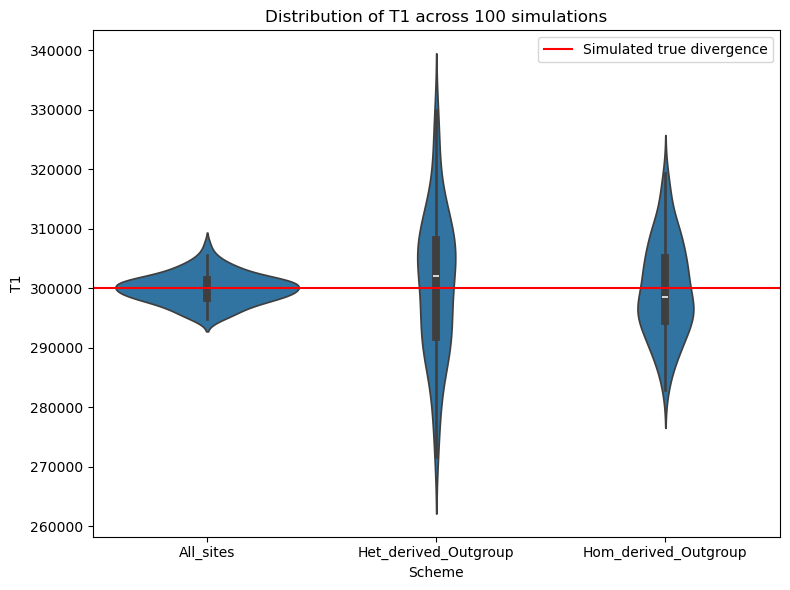

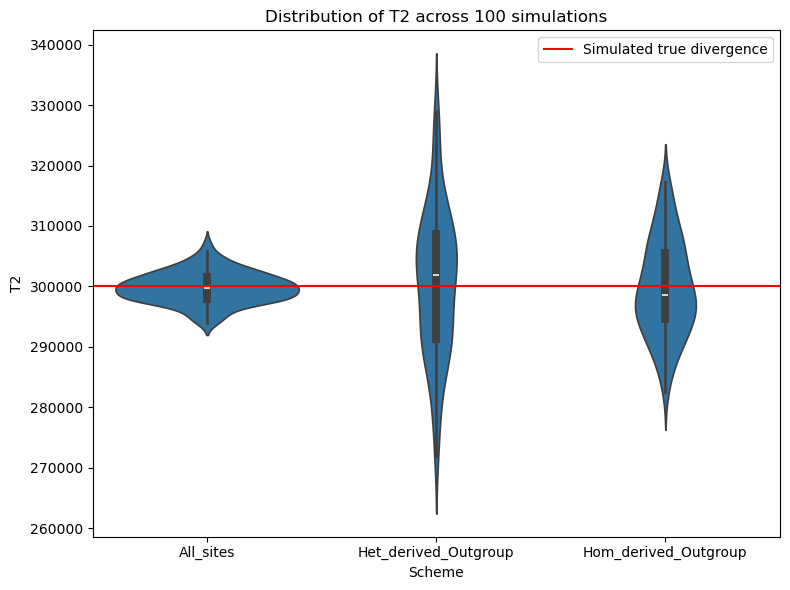

In [16]:
### Plot violin plots across simulations

params_to_plot = ['T1','T2']
for param in params_to_plot:
    plt.figure(figsize=(8,6))
    sns.violinplot(
        data=no_structure_df[no_structure_df['Parameter']==param],
        x='Scheme',
        y='Boot_mean'
    )
    plt.axhline(y=P.t_join_AB_y, color="r", linestyle="-", label="Simulated true divergence")
    plt.title(f"Distribution of {param} across {n_simulations} simulations")
    plt.ylabel(param)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Violin plots comparing simulation results from "No Ancestral Structure" and "Ancestral Structure"

In [29]:
plt.rcParams['xtick.labelsize'] = 12 # For x-tick labels
plt.rcParams['ytick.labelsize'] = 12 # For y-tick labels

/tmp/ipykernel_5425/3189165860.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["T1","T2","T1","T2"])


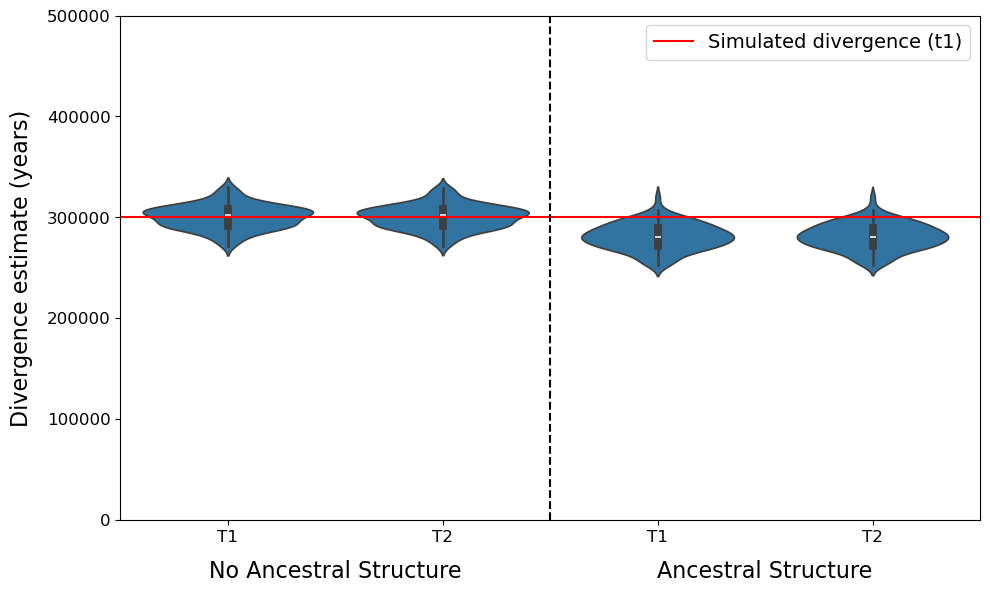

In [32]:
# Subset and label
anc_subset = anc_structure_df[anc_structure_df["Scheme"] == "Het_derived_Outgroup"].copy()
anc_subset["Dataset"] = "Ancestral Structure"

no_subset = no_structure_df[no_structure_df["Scheme"] == "Het_derived_Outgroup"].copy()
no_subset["Dataset"] = "No Ancestral Structure"

# Combine
combined = pd.concat([anc_subset, no_subset], ignore_index=True)

# Build x-axis groups: just T1/T2, repeated for each dataset
combined["Group"] = combined["Dataset"] + " - " + combined["Parameter"]

# Order
order = [
    "No Ancestral Structure - T1",
    "No Ancestral Structure - T2",
    "Ancestral Structure - T1",
    "Ancestral Structure - T2"
]

plt.figure(figsize=(10,6))
ax = sns.stripplot(
    data=combined[combined["Parameter"].isin(["T1","T2"])],
    x="Group",
    y="Boot_mean",
    order=order,
    jitter=True,              # spread points horizontally
    dodge=False,              # keep grouped by category
    alpha=0.7,                # make points slightly transparent
    color="steelblue"         # single color (or use palette=... for different colors)
)

# Add simulated truth line
plt.axhline(y=P.t_join_AB_y, color="r", linestyle="-", label="Simulated divergence (t1)")

# Fix tick labels to just T1/T2
ax.set_xticklabels(["T1","T2","T1","T2"])

# Add grouping labels beneath x-axis
ax.text(0.25, -0.08, "No Ancestral Stratification", transform=ax.transAxes,
        ha="center", va="top", fontsize=16)
ax.text(0.75, -0.08, "Ancestral Stratification", transform=ax.transAxes,
        ha="center", va="top", fontsize=16)

# Add vertical dividing line between datasets (between tick 1 and 2)
ax.axvline(1.5, color="black", linestyle="--")

ax.set_ylabel("Divergence estimate (years)", fontsize=16, labelpad=10)
plt.ylim(0, 500000)
plt.xlabel("")
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(f"Figures/NaturePaper/n100_BothModels_stripplot_2.pdf")
plt.show()